In [28]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
IMG_HEIGHT, IMG_WIDTH = 32, 32
NUM_CLASSES = 43
DATA_PATH = "/kaggle/input/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Train"

In [3]:
def load_data(data_path):
    images, labels = [], []
    for category in range(NUM_CLASSES):
        class_dir = os.path.join(data_path, str(category))
        for img_file in os.listdir(class_dir):
            try:
                img_path = os.path.join(class_dir, img_file)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
                images.append(image)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                
    # Normalize pixel values to [0, 1]
    images = np.array(images) / 255.0
    labels = to_categorical(np.array(labels), NUM_CLASSES)
    return images, labels

In [4]:
X, y = load_data(DATA_PATH)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
len(X)

39209

In [7]:
# Augmentation strategy
aug = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode="nearest"
)

In [16]:
def build_model():
    model = Sequential([
        Input((IMG_HEIGHT, IMG_WIDTH, 3)),
        # Block 1
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        # Classification Head
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [17]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 910,155 (3.47 MB)

 Trainable params: 908,747 (3.47 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [19]:
EPOCHS = 30
BATCH_SIZE = 64

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.000001
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[learning_rate_reduction, early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1771391081.806408     158 service.cc:152] XLA service 0x7fe6ec002410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771391081.806450     158 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771391081.806454     158 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771391082.472728     158 cuda_dnn.cc:529] Loaded cuDNN version 91002


  6/491 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.0202 - loss: 4.8125    

I0000 00:00:1771391087.834396     158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4105 - loss: 2.2830 - val_accuracy: 0.8221 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8545 - loss: 0.4599 - val_accuracy: 0.9814 - val_loss: 0.0631 - learning_rate: 0.0010
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9297 - loss: 0.2252 - val_accuracy: 0.9950 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9567 - loss: 0.1397 - val_accuracy: 0.9917 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 5/30
490/491 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9684 - loss: 0.0997
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9684 - loss: 0.0997 - val_accuracy: 0.9949 - val_loss: 0.0164 - learning_rate: 0.0010
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9794 - loss: 0.0672 -

In [23]:
model.save("traffic_sign_model.keras")

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy: 99.95%


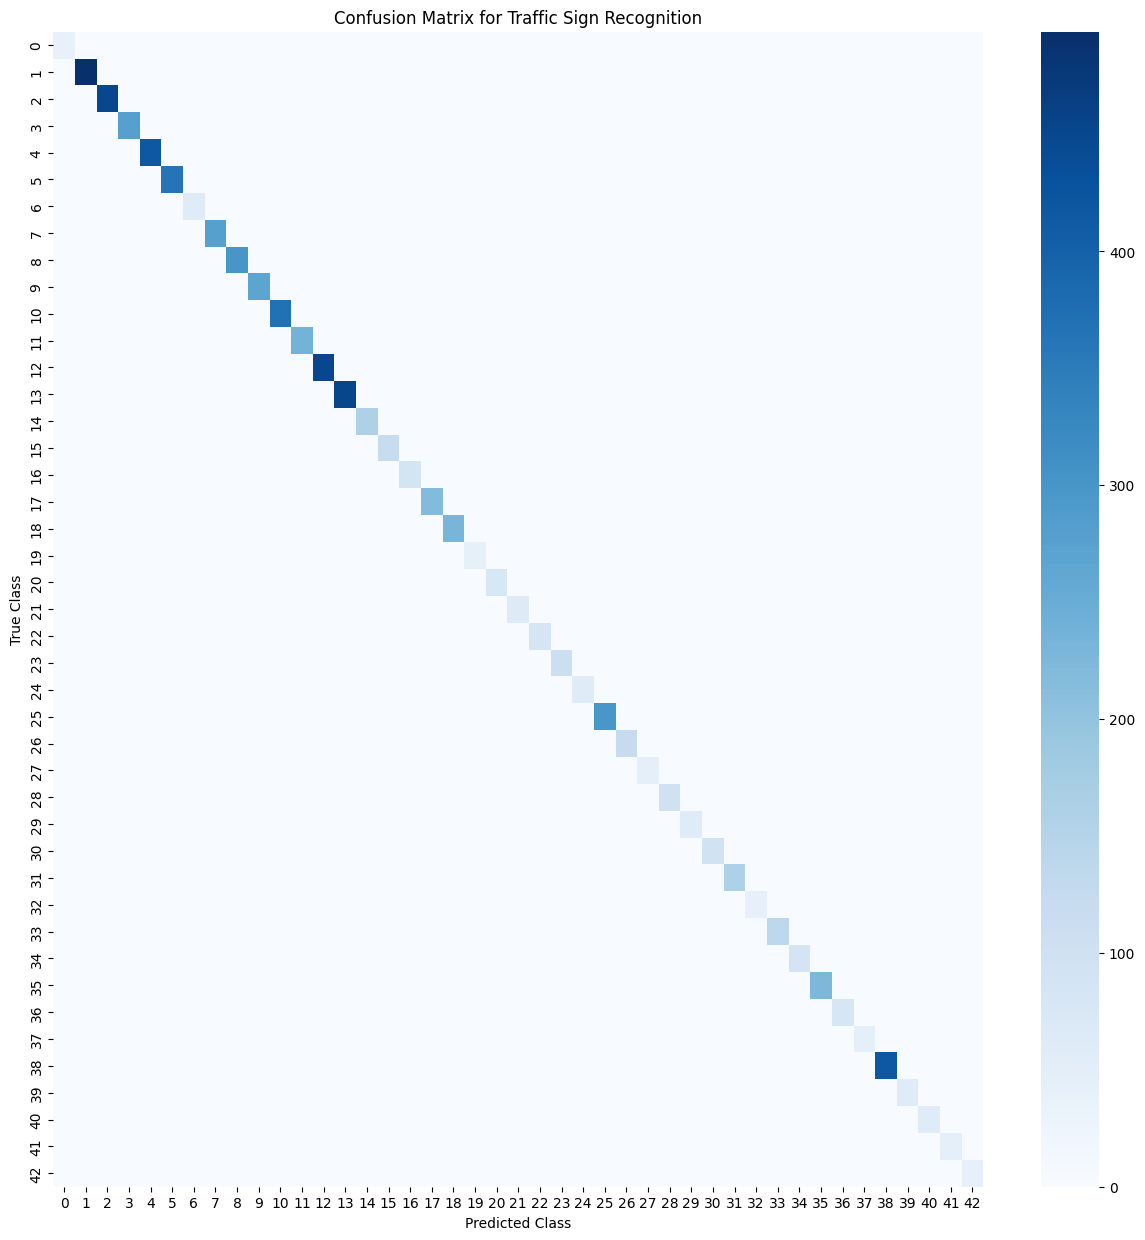

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Generate predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Accuracy
acc = accuracy_score(y_true_classes, y_pred_classes)
print(f"Validation Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix for Traffic Sign Recognition")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### The camera does not work on Kaggle notebook but I tried it locally and it works

In [30]:
# Load trained model
model = load_model("/kaggle/working/traffic_sign_model.keras")

# Setup webcam (0 is usually the default camera)
cap = cv2.VideoCapture(0)

class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    # Define a Region of Interest (ROI) box in the center of the screen
    cv2.rectangle(frame, (200, 100), (440, 340), (0, 255, 0), 2)
    roi = frame[100:340, 200:440]
    
    # Preprocess the ROI
    img = cv2.resize(roi, (32, 32))
    img = img / 255.0
    img = np.expand_dims(img, axis=0) # Add batch dimension
    
    # Predict
    predictions = model.predict(img, verbose=0)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)
    
    if confidence > 0.75: # Only show confident predictions
        label = class_names.get(class_id, 'Unknown')
        cv2.putText(frame, label, (200, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow("Traffic Sign Recognition", frame)
    
    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@5046.656] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@5046.656] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range
